翻译自：Machine Learning for Finance（第四章）
![book](./img/ml_finance.jpg)
链接：https://book.douban.com/subject/30220489/

时间序列是一种具有时间维度的数据形式，最具标志性的就是金融数据。虽然单个股票报价不是时间序列，但将您通过将每天获得的报价拿来并排列它们，就会得到更有趣的时间序列。几乎所有与金融有关的媒体材料迟早都会报道股价差距，而不是给定时刻的价格清单，而是随着时间的推移价格的发展。
您经常会听到财务评论员讨论价格走势：“Apple Inc.上涨5％。” 但是，这是什么意思？您所听到的绝对价值要少得多，例如，“Apple Inc.的股价为137.74美元。” 同样，这是什么意思？之所以会这样，是因为市场参与者对未来的发展趋势很感兴趣，并且他们试图从过去的发展趋势中推断出这些未来的预测。
![1.1](./img/1.1.png)

大多数预测都涉及查看一段时间内的过去发展情况。时间序列数据集的概念是与预测相关的重要元素。例如，农民在预测农作物产量时将查看时间序列数据集。因此，在统计，计量经济学和工程学领域中已经开发出了大量与时间序列相关的知识和工具。

在本章中，我们将研究一些今天仍然非常相关的经典工具。然后，我们将学习神经网络如何处理时间序列，以及深度学习模型如何表达不确定性。

在我们着眼于时间序列之前，我需要设定您对本章的期望。你们中许多人可能已经读过本章，以了解有关股票市场的预测，但是我需要警告您，本章与股票市场的预测无关，其他章节也不会涉及。
经济理论表明，市场有些有效。有效市场假说指出，所有公开可用的信息都包含在股票价格中。这扩展到有关如何处理信息的信息，例如“预测算法”。

如果这本书提出一种可以预测股市价格并带来丰厚回报的算法，那么许多投资者只会简单地实现该算法。由于这些算法都会在预期价格变化的情况下进行买卖，因此它们会改变当前的价格，从而破坏了使用该算法将获得的优势。因此，提出的算法不适用于将来的读者。

相反，本章将使用维基百科的流量数据。我们的目标是预测特定Wikipedia页面的访问量。我们可以通过Wikipediatrend CRAN包获取Wikipedia流量数据。

我们在这里使用的数据集是Google提供的大约145,000个Wikipedia页面的流量数据。数据可以从Kaggle获得。

数据可以从以下位置获取：

- https://www.kaggle.com/c/web-traffic-time-series-forecasting

- https://www.kaggle.com/muonneutrino/wikipedia-traffic-data-exploratio

# [pandas的可视化与准备工作](#content)

在开始训练之前获得数据整体概述通常是一个好主意。针对我们从Kaggle获得的数据，您可以通过运行以下操作实现此目标：

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
train = pd.read_csv("./data/train_1.csv").fillna(0)
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


页面列中的数据包含页面名称，维基百科页面的语言，访问设备的类型和访问代理。
其他列包含该日期与该页面的点击量。

因此，在上表中，第一行包含通过所有访问方式在中文版的Wikipedia上朝鲜流行乐队2NE1的页面，但仅适用于被归类为爬虫代理商的数据。也就是说，流量是通过爬虫访问的数据量。尽管大多数时间序列工作都集中在与时间相关的局部特征上，但我们可以通过提供对全局特征的访问来丰富所有模型。
因此，我们希望将页面字符串拆分为更小，更有用的功能。我们可以通过运行以下代码来实现此目的：

In [15]:
def parse_page(page):
    x = page.split('_')
    return ' '.join(x[:-3]), x[-3], x[-2], x[-1]

我们用下划线将字符串分开。页面名称中还可以包含下划线，因此我们将最后三个字段分开，然后将其余字段合并在一起以获取本文的主题。
如下面的代码所示，倒数第二个元素是子URL，例如，en.wikipedia.org。倒数第二个元素是访问权限，最后一个元素是代理：

In [16]:
parse_page(train.Page[0])

('2NE1', 'zh.wikipedia.org', 'all-access', 'spider')

当我们将此功能应用于训练集中的每个页面条目时，我们将获得一个元组列表，然后我们可以将其合并到一个新的DataFrame中，如下面的代码所示：

In [17]:
l = list(train.Page.apply(parse_page))
df = pd.DataFrame(l)
df.columns = ['Subject','Sub_Page','Access','Agent']

最后，我们必须在删除原始页面列之前将此新的DataFrame添加回我们的原始DataFrame中，我们可以通过运行以下操作来做到这一点：

In [18]:
train = pd.concat([train, df], axis = 1)
del train['Page']

In [19]:
train.head()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,Subject,Sub_Page,Access,Agent
0,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,...,14.0,20.0,22.0,19.0,18.0,20.0,2NE1,zh.wikipedia.org,all-access,spider
1,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,...,9.0,30.0,52.0,45.0,26.0,20.0,2PM,zh.wikipedia.org,all-access,spider
2,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,...,4.0,4.0,6.0,3.0,4.0,17.0,3C,zh.wikipedia.org,all-access,spider
3,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,...,16.0,11.0,17.0,19.0,10.0,11.0,4minute,zh.wikipedia.org,all-access,spider
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,11.0,27.0,13.0,36.0,10.0,52 Hz I Love You,zh.wikipedia.org,all-access,spider


运行此代码的结果是，我们成功完成了数据集的加载。这意味着我们现在可以继续探索它。

## [汇总全局特征统计](#content)

经过所有这些艰苦的工作，我们现在可以创建一些有关全局特征的汇总统计信息。

使用pandas value_counts()函数可以轻松绘制全局特征的分布图。通过运行以下代码，我们将获得Wikipedia数据集的条形图输出：

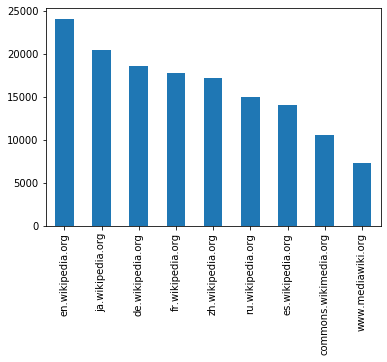

In [20]:
train.Sub_Page.value_counts().plot(kind='bar')
plt.show()

维基百科具有不同语言的子页面，我们可以看到我们的数据集包含来自英语（en），日语（ja），德语（de），法语（fr），中文（zh），俄语（ru）和西班牙语的页面 （es）维基百科站点。

在我们制作的条形图中，您可能还注意到了两个基于非国家/地区的Wikipedia网站。
commons.wikimedia.org 和 www.mediawiki.org 都用于托管媒体文件，例如图像。

让我们再次运行该命令，这次重点关注访问类型：

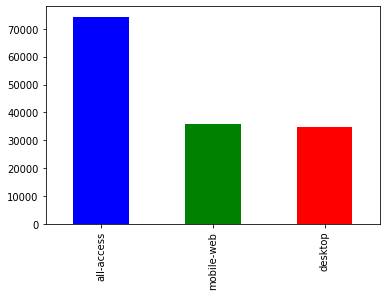

In [25]:
train.Access.value_counts().plot(kind='bar', color={"r", "g", "b"})
plt.show()

有两种可能的访问方法：移动和桌面。还有第三个选项全访问，它结合了移动和桌面访问的统计信息。

然后，我们可以通过运行以下代码来按代理绘制记录的分布图：

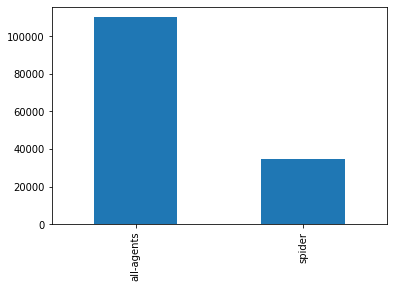

In [26]:
train.Agent.value_counts().plot(kind='bar')
plt.show()

时间序列不仅适用于爬虫，而且适用于所有其他类型的访问。在经典统计建模中，下一步将是分析每个全局特征的影响并围绕它们构建模型。但是，如果有足够的数据和计算能力可用，这不是必需的。

神经网络能够发现全局特征本身的影响，并根据它们之间的相互作用来创建新特征。对于全局功能，只有两个实际的考虑需要解决：

- 特征分布是否偏斜？如果是这种情况，那么可能只有少数具有全局特征的实例，我们的模型可能会过度适合于该全局特征。想象一下，在数据集中只有很少的中文维基百科的“文章”。该算法可能会基于特征区分太多，然后过度拟合了少数中文条目。我们的分布相对均匀，因此我们不必为此担心。

- 可以轻松编码特征吗？某些全局功能不能一键编码。想象一下，我们获得了带有时间序列的Wikipedia文章的全文。不能立即使用此功能，因为必须进行一些繁重的预处理才能使用它。在我们的案例中，有一些相对简单的类别可以进行一键编码。但是，主题名称不能一键编码，因为主题名称过多。

## [检查样本时间序列](#content)

要检查数据集的全局特征，我们必须查看一些示例时间序列，以了解我们可能面临的挑战。在本部分中，我们将为美国音乐人Twenty One Pilot的英语语言页面绘制视图。

绘制实际的网页浏览量以及10天的滚动平均值。我们可以通过运行以下代码来做到这一点：

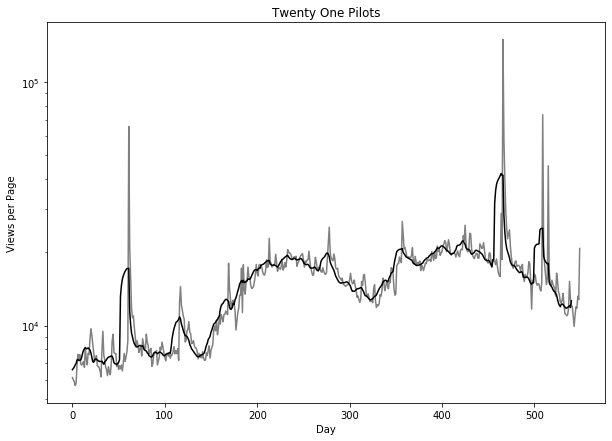

In [29]:
idx = 39457
window = 10
data = train.iloc[idx,0:-4]
name = train.iloc[idx, -4]
days = [r for r in range(data.shape[0])]
fig, ax = plt.subplots(figsize=(10,7))
plt.ylabel('Views per Page')
plt.xlabel('Day')
plt.title(name)

ax.plot(days,data.values,color='grey')
ax.plot(np.convolve(data, 
                    np.ones((window,))/window, 
                    mode='valid'),color='black')
ax.set_yscale('log')